# Using Labels from Different Relation Types to Predict Compound Treats Disease Sentences

This notebook is designed to predict the compound treats disease (CtD) relation. The first step in this process is to load our pre-labeled annotation matricies (train, dev, and test). These matriceis contain sentences as the rows and the label function output as the columns (features). The working hypothesis here is there are shared information (i.e. similar keywords, same kind of sentence structure) between different relations, which in turn should aid in predicting disease associates gene relations. 

After loading the matricies, the next step is to train a generative model that will estimate the likelihood of the positive class: $P(\hat{Y}=1 \mid \text{label functions})$. The generative model does this by estimating the parameter $\mu$. This parameter represents the probability of a label function given the true class: $ P(\text{label function={0,1,2}} \mid Y={1 (+) / 0 (-)})$. Once $\mu$ has been estimated, calculating the likelihood becomes: $P(\hat{Y}=1 \mid \text{label functions}) = (\prod_{i=1}^{N} P(\text{label function}_{i} = 1 \mid \text{Y} = 1)) * P(Y = 1)$

Note: This process doesn't involve any sentence context, so the only information used here are categorical output.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import sys
import os
sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
from sklearn.metrics import (
    precision_recall_curve, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    auc, roc_curve, 
    average_precision_score
)
from utils.notebook_utils.train_model_helper import get_model_performance, train_model_random_lfs, sample_lfs
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

import plotnine
import seaborn as sns
import logging

logging.basicConfig(filename='logs.log', level='INFO')

In [2]:
label_destinations = {
    'train':"../data/label_matricies/train_sparse_matrix.tsv.xz",
    'dev':"../data/label_matricies/dev_sparse_matrix.tsv.xz",
    'test':"../data/label_matricies/test_sparse_matrix.tsv.xz"
}
label_matricies = {
    key:pd.read_csv(label_destinations[key], sep="\t").to_sparse()
    for key in label_destinations
}

In [3]:
label_matricies['train'] = label_matricies['train'].fillna(-2).to_dense().replace({-1:0, -2:-1})
label_matricies['dev'] = label_matricies['dev'].fillna(-2).to_dense().replace({-1:0, -2:-1})
label_matricies['test'] = label_matricies['test'].fillna(-2).to_dense().replace({-1:0, -2:-1})

In [4]:
correct_L = label_matricies['train'].drop("candidate_id", axis=1).to_numpy()
correct_L_dev = label_matricies['dev'].drop("candidate_id", axis=1).to_numpy()
correct_L_test = label_matricies['test'].drop("candidate_id", axis=1).to_numpy()

In [5]:
spreadsheet_names = {
    #'train': 'data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [6]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_ctd")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [7]:
baseline_index = list(range(0,3))
train_grid_results, dev_grid_results, test_grid_results, models = (
    train_model_random_lfs(
        [baseline_index], correct_L, 
        correct_L_dev, candidate_dfs['dev'].curated_ctd, correct_L_test, 
        pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)
    )
)

In [8]:
(
    pd.DataFrame({key:train_grid_results[key][:,1] for key in train_grid_results})
    .assign(candidate_id=label_matricies['train'].candidate_id.values)
    .to_csv(f"results/CtD/marginals/baseline_sampled.tsv.xz", compression="xz", sep="\t", index=False)
)

In [9]:
dev_baseline_df = get_model_performance(candidate_dfs['dev'].curated_ctd, dev_grid_results, 0)
dev_baseline_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.491901,0.681995,0,"0:0,1,2"


In [10]:
test_baseline_df = get_model_performance(candidate_dfs['test'].curated_ctd, test_grid_results, 0)
test_baseline_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.289713,0.521712,0,"0:0,1,2"


# Compound Treats Disease Sources Predicts Compound Treats Disease Sentences

Here we are using label functions, designed to predict the Compound treats Disease relation, to predict Compound treats Disease sentences. To estimate the performance boost over the baseline model, we implement a label function sampling appoach. The sampling approach works as follows: 
1. randomly sample X amount of label functions that are not within the database category
2. incorporate the sampled label functions with the database label functions
3. train the generative model on the combined resources
4. use the generative model to predict the tuning set and test set
5. Report performance in terms of AUROC and AUPR
6. repeat the above process 50 times for each sample size (1, 6, 11, 16, all).

Given that these label functions are designed to predict the given relation, we expect that adding more label functions will increase in performance. This means that auroc when sampling 1 label function should be greater than the auroc of the baseline. This trend should continue when sampling 6, 11, 16 and then all of the label functions.

In [11]:
ctd_start = 3
ctd_end = 25

#Spaced out number of sampels including total
size_of_samples = [1,6,11,16,ctd_end-ctd_start]
number_of_samples = 50
ctd_lf_range = range(ctd_start, ctd_end)

In [12]:
sampled_lfs_dict = {
    sample_size:(
        sample_lfs(
            list(ctd_lf_range),
            len(list(ctd_lf_range)), 
            sample_size, 
            number_of_samples, 
            random_state=100
        )
    )
    for sample_size in size_of_samples
}

In [13]:
dev_records = []
test_records = []
for num_lf in sampled_lfs_dict:
    train_grid_results, dev_grid_results, test_grid_results, models = (
        train_model_random_lfs(
            [baseline_index + sample for sample in sampled_lfs_dict[num_lf]],
            correct_L, correct_L_dev, candidate_dfs['dev'].curated_ctd, 
            correct_L_test,pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)
        )
    )
    
    (
        pd.DataFrame({key:train_grid_results[key][:,1] for key in train_grid_results})
        .assign(candidate_id=label_matricies['train'].candidate_id.values)
        .to_csv(f"results/CtD/marginals/{num_lf}_sampled_train.tsv.xz", compression="xz", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:dev_grid_results[key][:,1] for key in dev_grid_results})
        .to_csv(f"results/CtD/marginals/{num_lf}_sampled_dev.tsv", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:test_grid_results[key][:,1] for key in test_grid_results})
        .to_csv(f"results/CtD/marginals/{num_lf}_sampled_test.tsv", index=False, sep="\t")
    )
    
    (
        pd.DataFrame({key:models[key].get_weights() for key in models})
        .to_csv(f"results/CtD/weights/{num_lf}_sampled_weights.tsv", index=False, sep="\t")
    )
    
    dev_records.append(get_model_performance(candidate_dfs['dev'].curated_ctd, dev_grid_results, num_lf))
    test_records.append(get_model_performance(candidate_dfs['test'].curated_ctd, test_grid_results, num_lf))

In [14]:
dev_full_results_df = pd.concat([dev_baseline_df] + dev_records).reset_index(drop=True)
dev_full_results_df.to_csv("results/CtD/results/dev_sampled_results.tsv", index=False, sep="\t")
dev_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.491901,0.681995,0,"0:0,1,2"
1,0.403564,0.689705,1,"0:0,1,2,17"


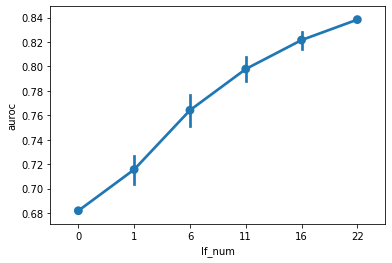

In [59]:
sns.pointplot(x='lf_num', y='auroc', data=dev_full_results_df)

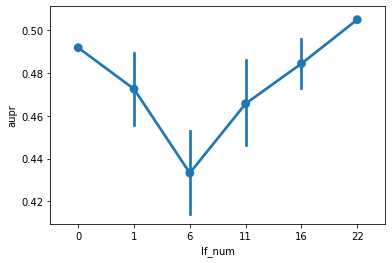

In [60]:
sns.pointplot(x='lf_num', y='aupr', data=dev_full_results_df)

In [15]:
test_full_results_df = pd.concat([test_baseline_df] + test_records).reset_index(drop=True)
test_full_results_df.to_csv("results/CtD/results/test_sampled_results.tsv", index=False, sep="\t")
test_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.289713,0.521712,0,"0:0,1,2"
1,0.299367,0.566481,1,"0:0,1,2,17"


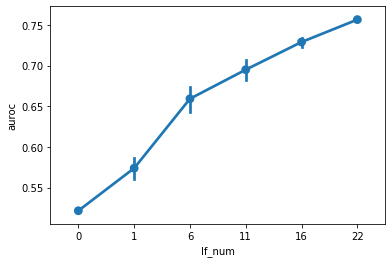

In [61]:
sns.pointplot(x='lf_num', y='auroc', data=test_full_results_df)

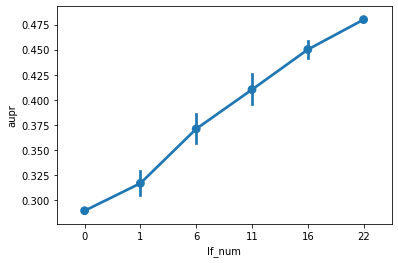

In [62]:
sns.pointplot(x='lf_num', y='aupr', data=test_full_results_df)

# Disease Associates Gene Sources Predicts Compound Treats Disease Sentences

Here we are using label functions, designed to predict the Disease associates Gene relation, to predict Compound treats Disease sentences. To estimate the performance boost over the baseline model, we implement a label function sampling appoach. The sampling approach works as follows: 
1. randomly sample X amount of label functions that are not within the database category
2. incorporate the sampled label functions with the database label functions
3. train the generative model on the combined resources
4. use the generative model to predict the tuning set and test set
5. Report performance in terms of AUROC and AUPR
6. repeat the above process 50 times for each sample size (1, 6, 11, 16, all).

Given that these label functions are not designed to predict the given relation, we expect that adding more label functions will decrease in performance. This means that auroc when sampling 1 label function should be less than the auroc of the baseline. This trend should continue when sampling 6, 11, 16 and then all of the label functions.

In [16]:
dag_start = 25
dag_end = 55

#Spaced out number of sampels including total
size_of_samples = [1,6,11,16,dag_end-dag_start]
number_of_samples = 50
dag_lf_range = range(dag_start, dag_end)

In [17]:
sampled_lfs_dict = {
    sample_size:(
        sample_lfs(
            list(dag_lf_range),
            len(list(dag_lf_range)), 
            sample_size, 
            number_of_samples, 
            random_state=100
        )
    )
    for sample_size in size_of_samples
}

In [18]:
dev_records = []
test_records = []
for num_lf in sampled_lfs_dict:
    train_grid_results, dev_grid_results, test_grid_results, models = (
        train_model_random_lfs(
            [baseline_index + sample for sample in sampled_lfs_dict[num_lf]],
            correct_L, correct_L_dev, candidate_dfs['dev'].curated_ctd,
            correct_L_test, pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)
        )
    )
    
    (
        pd.DataFrame({key:train_grid_results[key][:,1] for key in train_grid_results})
        .assign(candidate_id=label_matricies['train'].candidate_id.values)
        .to_csv(f"results/DaG/marginals/{num_lf}_sampled_train.tsv.xz", compression="xz", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:dev_grid_results[key][:,1] for key in dev_grid_results})
        .to_csv(f"results/DaG/marginals/{num_lf}_sampled_dev.tsv", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:test_grid_results[key][:,1] for key in test_grid_results})
        .to_csv(f"results/DaG/marginals/{num_lf}_sampled_test.tsv", index=False, sep="\t")
    )
    
    (
        pd.DataFrame({key:models[key].get_weights() for key in models})
        .to_csv(f"results/DaG/weights/{num_lf}_sampled_weights.tsv", index=False, sep="\t")
    )
    
    dev_records.append(get_model_performance(candidate_dfs['dev'].curated_ctd, dev_grid_results, num_lf))
    test_records.append(get_model_performance(candidate_dfs['test'].curated_ctd, test_grid_results, num_lf))

In [19]:
dev_full_results_df = pd.concat([dev_baseline_df] + dev_records).reset_index(drop=True)
dev_full_results_df.to_csv("results/DaG/results/dev_sampled_results.tsv", index=False, sep="\t")
dev_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.491901,0.681995,0,"0:0,1,2"
1,0.492823,0.685979,1,"0:0,1,2,40"


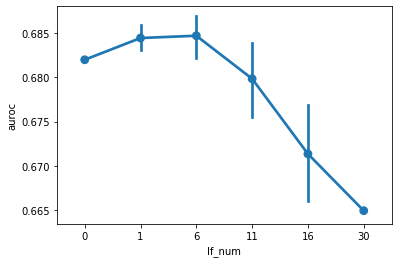

In [54]:
sns.pointplot(x='lf_num', y='auroc', data=dev_full_results_df)

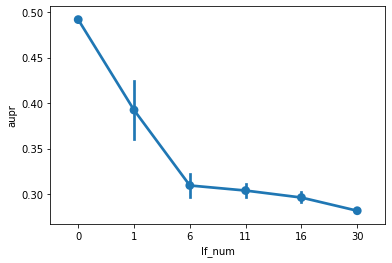

In [55]:
sns.pointplot(x='lf_num', y='aupr', data=dev_full_results_df)

In [20]:
test_full_results_df = pd.concat([test_baseline_df] + test_records).reset_index(drop=True)
test_full_results_df.to_csv("results/DaG/results/test_sampled_results.tsv", index=False, sep="\t")
test_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.289713,0.521712,0,"0:0,1,2"
1,0.286203,0.514612,1,"0:0,1,2,40"


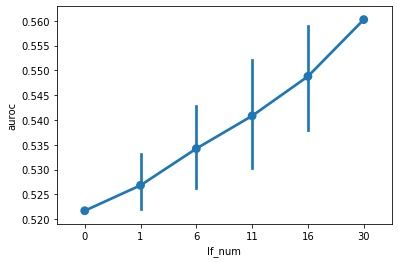

In [56]:
sns.pointplot(x='lf_num', y='auroc', data=test_full_results_df)

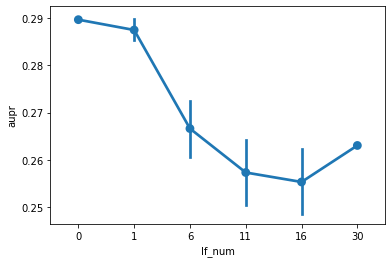

In [57]:
sns.pointplot(x='lf_num', y='aupr', data=test_full_results_df)

# Compound Binds Gene Sources Predicts Compound Treats Disease Sentences

Here we are using label functions, designed to predict the Compound binds Gene relation, to predict Compound treats Disease sentences. To estimate the performance boost over the baseline model, we implement a label function sampling appoach. The sampling approach works as follows: 
1. randomly sample X amount of label functions that are not within the database category
2. incorporate the sampled label functions with the database label functions
3. train the generative model on the combined resources
4. use the generative model to predict the tuning set and test set
5. Report performance in terms of AUROC and AUPR
6. repeat the above process 50 times for each sample size (1, 6, 11, 16, all).

Given that these label functions are not designed to predict the given relation, we expect that adding more label functions will decrease in performance. This means that auroc when sampling 1 label function should be less than the auroc of the baseline. This trend should continue when sampling 6, 11, 16 and then all of the label functions.

In [21]:
cbg_start = 55
cbg_end = 75

#Spaced out number of sampels including total
size_of_samples = [1,6,11,16,cbg_end-cbg_start]
number_of_samples = 50
cbg_lf_range = range(cbg_start, cbg_end)

In [22]:
sampled_lfs_dict = {
    sample_size:(
        sample_lfs(
            list(cbg_lf_range),
            len(list(cbg_lf_range)), 
            sample_size, 
            number_of_samples, 
            random_state=100
        )
    )
    for sample_size in size_of_samples
}

In [23]:
dev_records = []
test_records = []
for num_lf in sampled_lfs_dict:
    train_grid_results, dev_grid_results, test_grid_results, models = (
        train_model_random_lfs(
            [baseline_index + sample for sample in sampled_lfs_dict[num_lf]],
            correct_L, correct_L_dev, candidate_dfs['dev'].curated_ctd,
            correct_L_test,pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)
        )
    )
    
    (
        pd.DataFrame({key:train_grid_results[key][:,1] for key in train_grid_results})
        .assign(candidate_id=label_matricies['train'].candidate_id.values)
        .to_csv(f"results/CbG/marginals/{num_lf}_sampled_train.tsv.xz", compression="xz", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:dev_grid_results[key][:,1] for key in dev_grid_results})
        .to_csv(f"results/CbG/marginals/{num_lf}_sampled_dev.tsv", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:test_grid_results[key][:,1] for key in test_grid_results})
        .to_csv(f"results/CbG/marginals/{num_lf}_sampled_test.tsv", index=False, sep="\t")
    )
    
    (
        pd.DataFrame({key:models[key].get_weights() for key in models})
        .to_csv(f"results/CbG/weights/{num_lf}_sampled_weights.tsv", index=False, sep="\t")
    )
    
    dev_records.append(get_model_performance(candidate_dfs['dev'].curated_ctd, dev_grid_results, num_lf))
    test_records.append(get_model_performance(candidate_dfs['test'].curated_ctd, test_grid_results, num_lf))

In [24]:
dev_full_results_df = pd.concat([dev_baseline_df] + dev_records).reset_index(drop=True)
dev_full_results_df.to_csv("results/CbG/results/dev_sampled_results.tsv", index=False, sep="\t")
dev_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.491901,0.681995,0,"0:0,1,2"
1,0.496022,0.709880,1,"0:0,1,2,59"


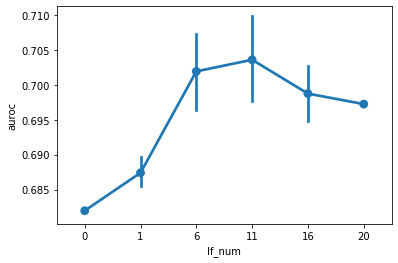

In [49]:
sns.pointplot(x='lf_num', y='auroc', data=dev_full_results_df)

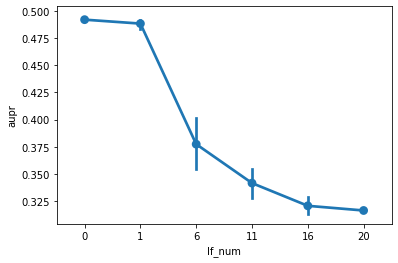

In [50]:
sns.pointplot(x='lf_num', y='aupr', data=dev_full_results_df)

In [25]:
test_full_results_df = pd.concat([test_baseline_df] + test_records).reset_index(drop=True)
test_full_results_df.to_csv("results/CbG/results/test_sampled_results.tsv", index=False, sep="\t")
test_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.289713,0.521712,0,"0:0,1,2"
1,0.293653,0.563466,1,"0:0,1,2,59"


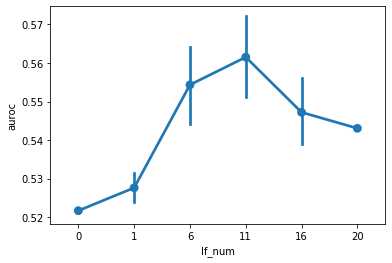

In [51]:
sns.pointplot(x='lf_num', y='auroc', data=test_full_results_df)

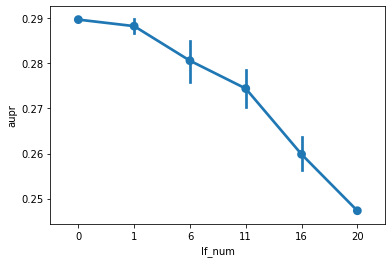

In [52]:
sns.pointplot(x='lf_num', y='aupr', data=test_full_results_df)

# Gene Interacts Gene Sources Predicts Compound Treats Disease Sentences

Here we are using label functions, designed to predict the Gene inteacts Gene relation, to predict Compound treats Disease sentences. To estimate the performance boost over the baseline model, we implement a label function sampling appoach. The sampling approach works as follows: 
1. randomly sample X amount of label functions that are not within the database category
2. incorporate the sampled label functions with the database label functions
3. train the generative model on the combined resources
4. use the generative model to predict the tuning set and test set
5. Report performance in terms of AUROC and AUPR
6. repeat the above process 50 times for each sample size (1, 6, 11, 16, all).

Given that these label functions are not designed to predict the given relation, we expect that adding more label functions will decrease in performance. This means that auroc when sampling 1 label function should be less than the auroc of the baseline. This trend should continue when sampling 6, 11, 16 and then all of the label functions.

In [26]:
gig_start = 75
gig_end = 103

#Spaced out number of sampels including total
size_of_samples = [1,6,11,16,gig_end-gig_start]
number_of_samples = 50
gig_lf_range = range(gig_start, gig_end)

In [27]:
sampled_lfs_dict = {
    sample_size:(
        sample_lfs(
            list(gig_lf_range),
            len(list(gig_lf_range)), 
            sample_size, 
            number_of_samples, 
            random_state=100
        )
    )
    for sample_size in size_of_samples
}

In [28]:
dev_records = []
test_records = []
for num_lf in sampled_lfs_dict:
    train_grid_results, dev_grid_results, test_grid_results, models = (
        train_model_random_lfs(
            [baseline_index + sample for sample in sampled_lfs_dict[num_lf]], 
            correct_L, correct_L_dev, candidate_dfs['dev'].curated_ctd, 
            correct_L_test, pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)
        )
    )
    
    (
        pd.DataFrame({key:train_grid_results[key][:,1] for key in train_grid_results})
        .assign(candidate_id=label_matricies['train'].candidate_id.values)
        .to_csv(f"results/GiG/marginals/{num_lf}_sampled_train.tsv.xz", compression="xz", sep="\t", index=False)
    )
    (
        pd.DataFrame({key:dev_grid_results[key][:,1] for key in dev_grid_results})
        .to_csv(f"results/GiG/marginals/{num_lf}_sampled_dev.tsv", sep="\t", index=False)
    )
    (
        pd.DataFrame({key:test_grid_results[key][:,1] for key in test_grid_results})
        .to_csv(f"results/GiG/marginals/{num_lf}_sampled_test.tsv", sep="\t", index=False)
    )
    
    (
        pd.DataFrame({key:models[key].get_weights() for key in models})
        .to_csv(f"results/GiG/weights/{num_lf}_sampled_weights.tsv", sep="\t", index=False)
    )
    
    dev_records.append(get_model_performance(candidate_dfs['dev'].curated_ctd, dev_grid_results, num_lf))
    test_records.append(get_model_performance(candidate_dfs['test'].curated_ctd, test_grid_results, num_lf))

In [29]:
dev_full_results_df = pd.concat([dev_baseline_df] + dev_records).reset_index(drop=True)
dev_full_results_df.to_csv("results/GiG/results/dev_sampled_results.tsv", index=False, sep="\t")
dev_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.491901,0.681995,0,"0:0,1,2"
1,0.495726,0.689150,1,"0:0,1,2,89"


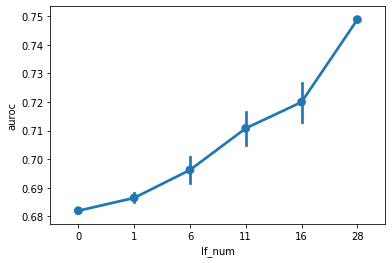

In [44]:
sns.pointplot(x='lf_num', y='auroc', data=dev_full_results_df)

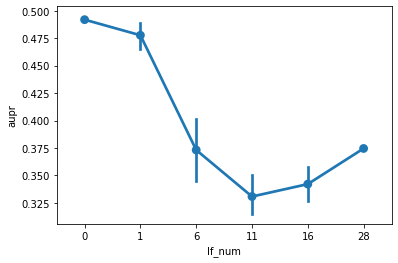

In [45]:
sns.pointplot(x='lf_num', y='aupr', data=dev_full_results_df)

In [30]:
test_full_results_df = pd.concat([test_baseline_df] + test_records).reset_index(drop=True)
test_full_results_df.to_csv("results/GiG/results/test_sampled_results.tsv", index=False, sep="\t")
test_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.289713,0.521712,0,"0:0,1,2"
1,0.292926,0.532147,1,"0:0,1,2,89"


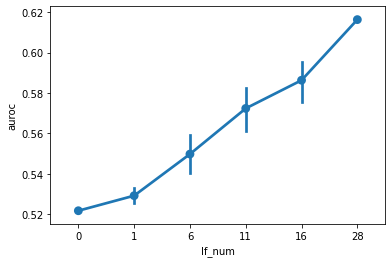

In [46]:
sns.pointplot(x='lf_num', y='auroc', data=test_full_results_df)

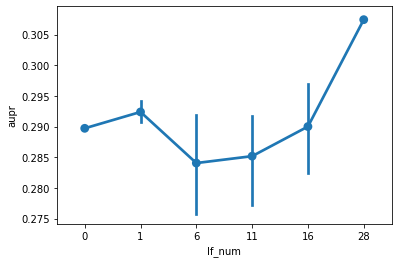

In [47]:
sns.pointplot(x='lf_num', y='aupr', data=test_full_results_df)

# All Sources Predicts Compound Treats Disease Sentences

Here we are using every hand constructed label function to predict Compound treats Disease sentences. To estimate the performance boost over the baseline model, we implement a label function sampling appoach. The sampling approach works as follows: 
1. randomly sample X amount of label functions that are not within the database category
2. incorporate the sampled label functions with the database label functions
3. train the generative model on the combined resources
4. use the generative model to predict the tuning set and test set
5. Report performance in terms of AUROC and AUPR
6. repeat the above process 50 times for each sample size (1, 33, 65, 97, all).

Given that some of these label functions are used to predict the given relation, we expect that adding more label functions might slightly increase performance. This means that auroc when sampling 1 label function should be higher than the auroc of the baseline; however, at 33, 65, 97 the auroc should start to decrease as we are adding more irrelevant label functions towards the baseline model.

In [31]:
all_start = 3
all_end = 103

#Spaced out number of sampels including total
size_of_samples = [1,33,65,97,all_end-all_start]
number_of_samples = 50
cbg_lf_range = range(all_start, all_end)

In [32]:
sampled_lfs_dict = {
    sample_size:(
        sample_lfs(
            list(cbg_lf_range),
            len(list(cbg_lf_range)), 
            sample_size, 
            number_of_samples, 
            random_state=100
        )
    )
    for sample_size in size_of_samples
}

In [33]:
dev_records = []
test_records = []
for num_lf in sampled_lfs_dict:
    train_grid_results, dev_grid_results, test_grid_results, models = (
        train_model_random_lfs(
            [baseline_index + sample for sample in sampled_lfs_dict[num_lf]],
            correct_L, correct_L_dev, candidate_dfs['dev'].curated_ctd,
            correct_L_test, pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)
        )
    )
    
    (
        pd.DataFrame({key:train_grid_results[key][:,1] for key in train_grid_results})
        .assign(candidate_id=label_matricies['train'].candidate_id.values)
        .to_csv(f"results/all/marginals/{num_lf}_sampled_train.tsv.xz", compression="xz", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:dev_grid_results[key][:,1] for key in dev_grid_results})
        .to_csv(f"results/all/marginals/{num_lf}_sampled_dev.tsv", index=False, sep="\t")
    )
    (
        pd.DataFrame({key:test_grid_results[key][:,1] for key in test_grid_results})
        .to_csv(f"results/all/marginals/{num_lf}_sampled_test.tsv", index=False, sep="\t")
    )
    
    (
        pd.DataFrame({key:models[key].get_weights() for key in models})
        .to_csv(f"results/all/weights/{num_lf}_sampled_weights.tsv", index=False, sep="\t")
    )
    
    dev_records.append(get_model_performance(candidate_dfs['dev'].curated_ctd, dev_grid_results, num_lf))
    test_records.append(get_model_performance(candidate_dfs['test'].curated_ctd, test_grid_results, num_lf))

In [34]:
dev_full_results_df = pd.concat([dev_baseline_df] + dev_records).reset_index(drop=True)
dev_full_results_df.to_csv("results/all/results/dev_sampled_results.tsv", index=False, sep="\t")
dev_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.491901,0.681995,0,"0:0,1,2"
1,0.240820,0.679481,1,"0:0,1,2,53"


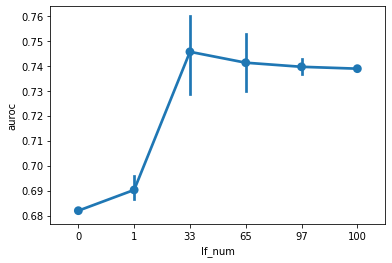

In [41]:
sns.pointplot(x='lf_num', y='auroc', data=dev_full_results_df)

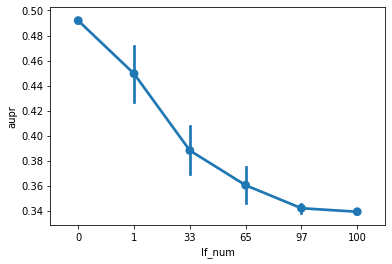

In [42]:
sns.pointplot(x='lf_num', y='aupr', data=dev_full_results_df)

In [35]:
test_full_results_df = pd.concat([test_baseline_df] + test_records).reset_index(drop=True)
test_full_results_df.to_csv("results/all/results/test_sampled_results.tsv", index=False, sep="\t")
test_full_results_df.head(2)

,aupr,auroc,lf_num,lf_sample
0,0.289713,0.521712,0,"0:0,1,2"
1,0.285343,0.518594,1,"0:0,1,2,53"


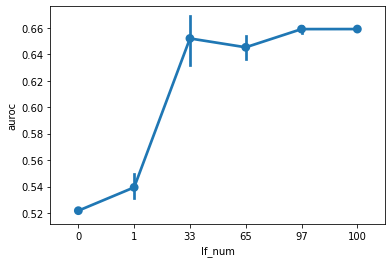

In [39]:
sns.pointplot(x='lf_num', y='auroc', data=test_full_results_df)

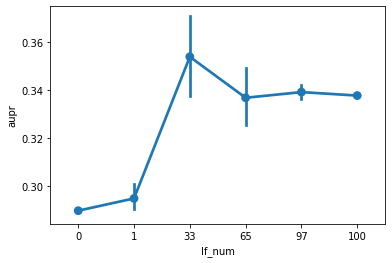

In [40]:
sns.pointplot(x='lf_num', y='aupr', data=test_full_results_df)